In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.visualization import make_lupton_rgb
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('dark_background')

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc

In [2]:
data_zoo = pd.read_csv('data/complete_data.csv')

filepath = '/Users/jimenagonzalez/research/DSPL/Citizen_science_project/Intersection/data/in_sled2.fits'
hdu_list = fits.open(filepath)
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()

data.replace('None', np.nan, inplace=True)
data = data.astype({'COADD_OBJECT_ID': int, 'K_RA': float, 'K_DEC': float, 'K_SCORE': float, 'Y3_COADD_OBJECT_ID': int,
       'J_RA': float, 'J_DEC': float, 'score_sims': float, 'score_real': float, 'score_both': float, 'G_RA': float,
       'G_DEC': float, 'SINGLE': float, 'RING': float, 'SMOOTH': float, 'COMPANIONS': float, 'SDSS_SPIRALS': float,
       'DES_SPIRALS': float, 'CROWDED': float, 'ARTIFACTS': float, 'MOST_NEGATIVES': float, 'index': int, 'ra': float,
       'dec': float, 'name': str, 'score': float, 'image_sep': float, 'info': str, 'n_img': float, 'flag': str,
       'image_conf': str, 'lens_type': str, 'source_type': str, 'contaminant_type': str, 'papers': str})

#Getting the images
data.set_index('COADD_OBJECT_ID', inplace=True)
data_zoo.set_index('COADD_OBJECT_ID', inplace=True)
# Reindex 'data' to match the index of 'data_zoo'
data = data.reindex(data_zoo.index)
# Reset index if needed
data.reset_index(inplace=True)
data_zoo.reset_index(inplace=True)
images = images[data.index]

In [3]:
list_refs = []

for i in range(len(data_zoo)):
    test = data_zoo['papers'].iloc[i].split(', ')
    for j in range(len(test)):
        list_refs.append(test[j])

pd_refs = pd.DataFrame(list_refs, columns=['papers'])
unique_refs = pd_refs.drop_duplicates(subset='papers').reset_index(drop=True)
unique_refs.to_csv('data/unique_refs.csv', index=False)

#Opening csv file with name of paper and survey
refs_citations = pd.read_csv('data/unique_refs_citation.csv')
unique_refs = unique_refs.merge(refs_citations[['papers', 'Name', 'Survey']], on='papers')
unique_refs['Number_cand'] = [0]*len(unique_refs)

for i in range(len(data_zoo)):
    papers = data_zoo['papers'].iloc[i].split(', ')
    for ref in papers:
        unique_refs.loc[unique_refs['papers'] == ref, 'Number_cand'] += 1
        
unique_refs = unique_refs.sort_values(by=['Survey', 'Number_cand'], ascending=[True, False])

## Origin of systems in sample inspected by experts

In [4]:
print('Number of references from inspected sample: ', len(unique_refs))
unique_refs.head()

Number of references from inspected sample:  42


,papers,Name,Survey,Number_cand
3,2019ApJS..243...17J,"Jacobs, 2019b",DES,602
0,2022A&A...668A..73R,"Rojas, 2022",DES,241
2,2017ApJS..232...15D,"Diehl, 2017",DES,79
4,2019MNRAS.484.5330J,"Jacobs, 2019a",DES,64
18,2022ApJS..259...27O,"O’Donnell, 2022",DES,43


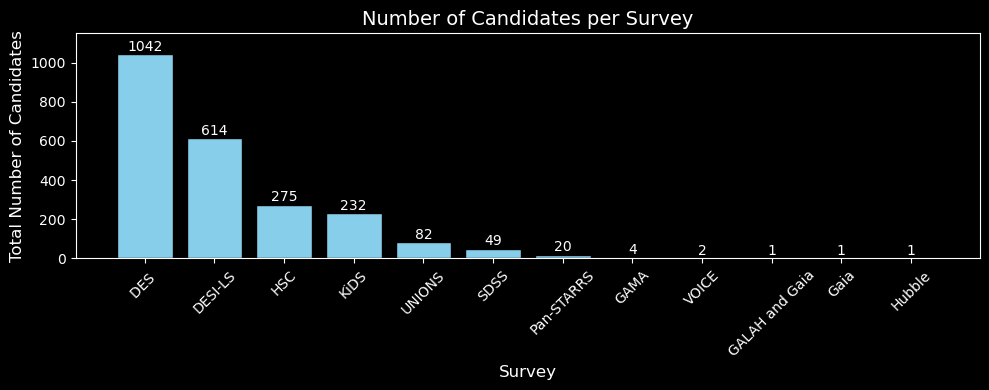

In [5]:
#Histogram representation

grouped = unique_refs.groupby('Survey', as_index=False)['Number_cand'].sum()
grouped = grouped.sort_values(by='Number_cand', ascending=False)

plt.figure(figsize=(10, 4))
bars = plt.bar(grouped['Survey'], grouped['Number_cand'], color='#87CEEB', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        height + 2,                         # Y position (a bit above the bar)
        f'{int(height)}',                  # Text
        ha='center', va='bottom', fontsize=10)

plt.xlabel('Survey', fontsize=12)
plt.ylabel('Total Number of Candidates', fontsize=12)
plt.title('Number of Candidates per Survey', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0, 1150)
plt.show()


## Studying Expert Scores, and how their average relates to other properties

Each expert inspected: 

Krojas26 1651
sgonzalezloz 1651
curiosorus 1651
ctortora 1651
clarkguilty 1651
alejandramelo 1651
anupreeta 340


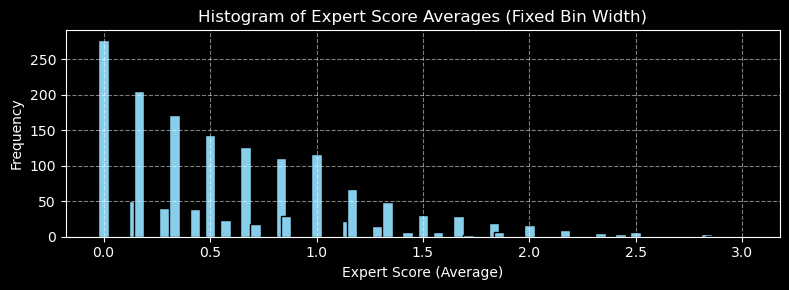

In [6]:
# How many systems did each expert clasify? & Expert Score Distribution
usernames = ['Krojas26', 'sgonzalezloz', 'curiosorus', 'ctortora', 'clarkguilty', 'alejandramelo', 'anupreeta']

print('Each expert inspected: \n' )
for user in usernames:
    print(user, len(data_zoo[user].dropna()))
    
counts = data_zoo['average'].value_counts().sort_index()
plt.figure(figsize=(8, 3))
plt.bar(counts.index, counts.values, width=0.05, color='skyblue', edgecolor='black')
#plt.yscale('log')
plt.xlabel('Expert Score (Average)')
plt.ylabel('Frequency')
plt.title('Histogram of Expert Score Averages (Fixed Bin Width)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

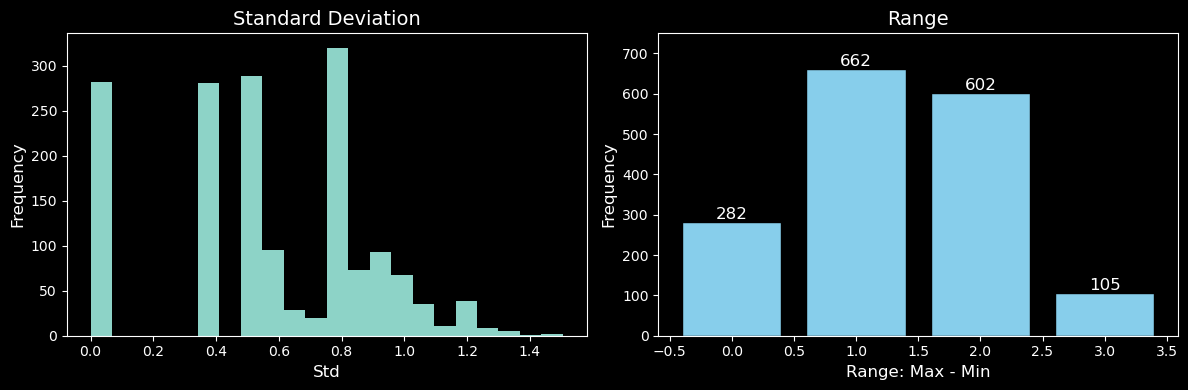

In [7]:
#How much do the experts agree? Histograms of standard deviation & range

data_zoo['score_std'] = data_zoo[usernames].std(axis=1)
data_zoo['score_range'] = data_zoo[usernames].max(axis=1) - data_zoo[usernames].min(axis=1)

#For Range histogram
range_counts = data_zoo['score_range'].value_counts().sort_index()
all_values = [0, 1, 2, 3]
range_counts = range_counts.reindex(all_values, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  
axes[0].hist(data_zoo['score_std'], bins='auto')
axes[0].set_title('Standard Deviation', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xlabel('Std', fontsize=12)
axes[1].bar(range_counts.index, range_counts.values, color='#87CEEB', edgecolor='black')
axes[1].set_title('Range', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_xlabel('Range: Max - Min', fontsize=12)
axes[1].set_ylim(0, 750)
for i, count in enumerate(range_counts.values):
    axes[1].text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

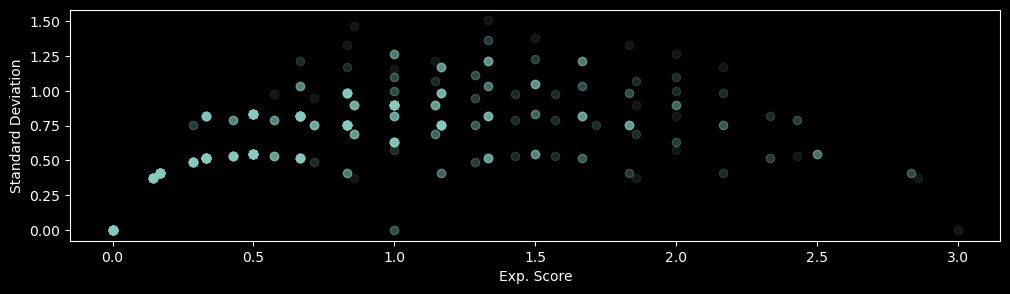

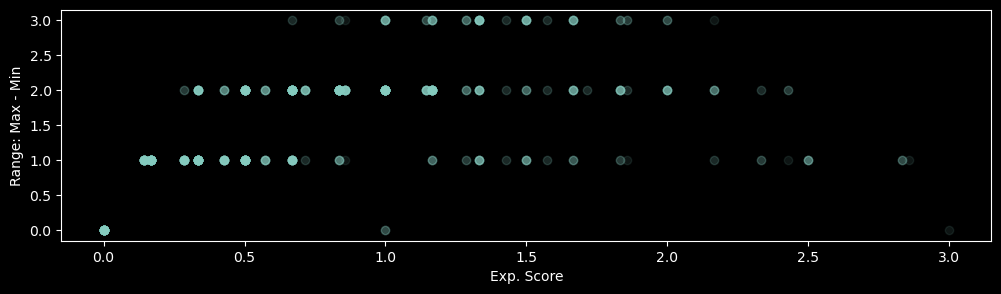

In [8]:
#Is there a relationship between average Exp. Score & Standard deviation or Range?

#Exp. score vs std
plt.figure(figsize=(12,3))
plt.plot(data_zoo['average'], data_zoo['score_std'], 'o', alpha=0.1)
plt.xlabel('Exp. Score')
plt.ylabel('Standard Deviation')
plt.show()

#Exp. score vs range
plt.figure(figsize=(12,3))
plt.plot(data_zoo['average'], data_zoo['score_range'], 'o', alpha=0.1)
plt.xlabel('Exp. Score')
plt.ylabel('Range: Max - Min')
plt.show()

Number systems average Exp. Score < 0.5:  784


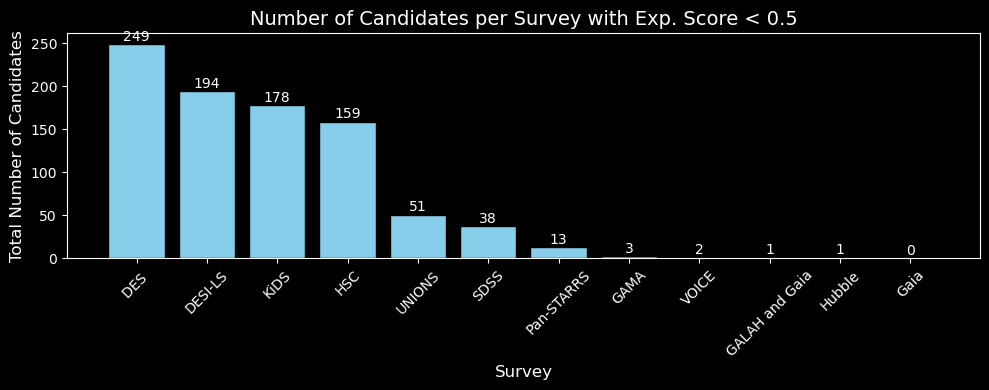

,papers,Name,Survey,Number_cand
3,2019ApJS..243...17J,"Jacobs, 2019b",DES,167
0,2022A&A...668A..73R,"Rojas, 2022",DES,36
2,2017ApJS..232...15D,"Diehl, 2017",DES,25
4,2019MNRAS.484.5330J,"Jacobs, 2019a",DES,13
18,2022ApJS..259...27O,"O’Donnell, 2022",DES,4


In [9]:
# Where do the candidates with average Exp. Score = 0 come from?

# General function
def filter_dataset(column_name, threshold):
    data_zoo_tmp = data_zoo[data_zoo[column_name] < threshold]
    unique_refs_tmp = unique_refs.copy()
    unique_refs_tmp['Number_cand'] = [0]*len(unique_refs)
    for i in range(len(data_zoo_tmp)):
        papers = data_zoo_tmp['papers'].iloc[i].split(', ')
        for ref in papers:
            unique_refs_tmp.loc[unique_refs_tmp['papers'] == ref, 'Number_cand'] += 1

    unique_refs_tmp = unique_refs_tmp.sort_values(by=['Survey', 'Number_cand'], ascending=[True, False])
    return(unique_refs_tmp)

threshold = 0.5
unique_refs_tmp = filter_dataset('average', threshold)
print('Number systems average Exp. Score < 0.5: ', len(data_zoo[data_zoo['average'] < 0.5]))

#Histogram representation
grouped = unique_refs_tmp.groupby('Survey', as_index=False)['Number_cand'].sum()
grouped = grouped.sort_values(by='Number_cand', ascending=False)
plt.figure(figsize=(10, 4))
bars = plt.bar(grouped['Survey'], grouped['Number_cand'], color='#87CEEB', edgecolor='black')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.2, f'{int(height)}', ha='center', va='bottom', fontsize=10)
plt.xlabel('Survey', fontsize=12)
plt.ylabel('Total Number of Candidates', fontsize=12)
plt.title('Number of Candidates per Survey with Exp. Score < 0.5', fontsize=14)
#plt.ylim(0, 110)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

unique_refs_tmp.head()

Number systems average Exp. Score < 0.5:  784


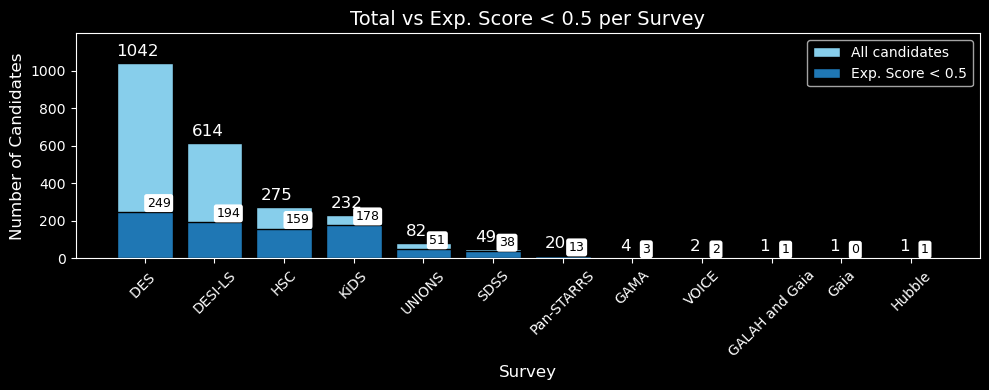

In [10]:
print('Number systems average Exp. Score < 0.5: ', len(data_zoo[data_zoo['average'] < 0.5]))

# Step 1: Group both datasets
grouped_all = unique_refs.groupby('Survey', as_index=False)['Number_cand'].sum()
grouped_tmp = unique_refs_tmp.groupby('Survey', as_index=False)['Number_cand'].sum()

# Step 2: Merge them into a single DataFrame
merged = pd.merge(grouped_all, grouped_tmp, on='Survey', how='left', suffixes=('_all', '_tmp'))
merged['Number_cand_tmp'] = merged['Number_cand_tmp'].fillna(0)  # Fill missing with 0
merged = merged.sort_values(by='Number_cand_all', ascending=False)

# Step 3: Plot
plt.figure(figsize=(10, 4))
bar1 = plt.bar(merged['Survey'], merged['Number_cand_all'], color='#87CEEB', edgecolor='black', label='All candidates')
bar2 = plt.bar(merged['Survey'], merged['Number_cand_tmp'], color='#1f77b4', edgecolor='black', label='Exp. Score < 0.5')

# Step 4: Annotate
for i in range(len(merged)):
    plt.text(i-0.1, merged['Number_cand_all'].iloc[i] + 20, int(merged['Number_cand_all'].iloc[i]),
             ha='center', va='bottom', fontsize=12)
    plt.text(i+0.2, merged['Number_cand_tmp'].iloc[i] + 11, int(merged['Number_cand_tmp'].iloc[i]),
                 ha='center', va='bottom', fontsize=9, color='black',
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

# Step 5: Labels and legend
plt.xlabel('Survey', fontsize=12)
plt.ylabel('Number of Candidates', fontsize=12)
plt.title('Total vs Exp. Score < 0.5 per Survey', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, merged['Number_cand_all'].max() * 1.15)
plt.legend()
plt.tight_layout()
plt.show()

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


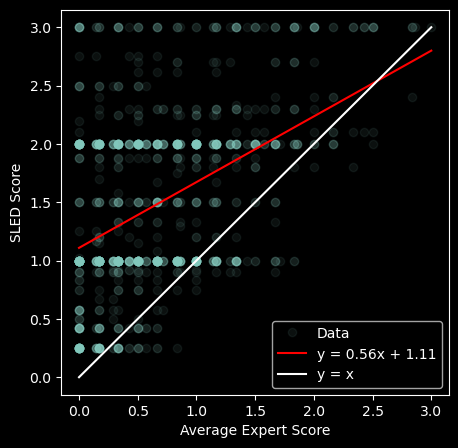

Percentage of points below y = x: 7.15%


In [11]:
#Is there a correlation between the SLED score and the average Exp. Score?

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(data_zoo['average'], data_zoo['score'])
x_fit = np.linspace(data_zoo['average'].min(), data_zoo['average'].max(), 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(5,5))
plt.plot(data_zoo['average'], data_zoo['score'], 'o', alpha=0.08, label='Data')
plt.plot(x_fit, y_fit, 'r-', label=f'y = {slope:.2f}x + {intercept:.2f}')
plt.plot(x_fit, x_fit, 'r-', label=f'y = x', color='white')
plt.xlabel('Average Expert Score')
plt.ylabel('SLED Score')
plt.legend()
plt.show()

below_y_equals_x = (data_zoo['score'] < data_zoo['average']).sum()
total_points = len(data_zoo)
percentage_below = 100 * below_y_equals_x / total_points
print(f"Percentage of points below y = x: {percentage_below:.2f}%")

## New Calibrated Expert Score

In [12]:
#usernames = ['Krojas26', 'sgonzalezloz', 'curiosorus', 'ctortora', 'clarkguilty', 'alejandramelo', 'anupreeta']

# Step 1: Get only the user score columns as a separate DataFrame
scores_only = data_zoo[usernames]

# Step 2: Apply row-wise function to remove min and max, and keep remaining scores
def remove_min_max(row):
    valid_scores = row.dropna().tolist()
    if len(valid_scores) <= 2:
        # Not enough values to remove min and max
        return pd.Series([None] * max(0, len(valid_scores) - 2))
    trimmed = sorted(valid_scores)[1:-1]  # Remove lowest and highest
    return pd.Series(trimmed, index=[f'user{i+1}' for i in range(len(trimmed))])


# Step 3: Apply to each row
data_zoo_tmp = data_zoo[usernames].apply(remove_min_max, axis=1)
data_zoo_tmp = pd.concat([data_zoo.drop(columns=usernames), data_zoo_tmp], axis=1)

new_usernames = ['user1', 'user2', 'user3', 'user4', 'user5']
data_zoo_tmp['calib'] = data_zoo_tmp[new_usernames].mean(axis=1)
data_zoo_tmp['calib_std'] = data_zoo_tmp[new_usernames].std(axis=1)
data_zoo_tmp['calib_range'] = data_zoo_tmp[new_usernames].max(axis=1) - data_zoo_tmp[new_usernames].min(axis=1)

data_zoo_tmp

,COADD_OBJECT_ID,K_RA,K_DEC,K_SCORE,Y3_COADD_OBJECT_ID,J_RA,J_DEC,score_sims,score_real,score_both,...,score_std,score_range,user1,user2,user3,user4,user5,calib,calib_std,calib_range
0,1538255919,78.309585,-52.505695,0.944468,413391817.0,78.309585,-52.505695,0.0000,0.0,0.0,...,0.752773,2.0,2.0,2.0,2.0,3.0,NaN,2.25,0.500000,1.0
1,1537731200,77.456831,-52.455477,0.411994,413390304.0,77.456831,-52.455477,0.0000,0.0,0.0,...,0.899735,2.0,0.0,1.0,1.0,2.0,2.0,1.20,0.836660,2.0
2,1510424134,72.587800,-50.743626,0.000009,483404421.0,72.587800,-50.743626,0.0000,0.0,0.0,...,0.836660,2.0,0.0,0.0,0.0,1.0,NaN,0.25,0.500000,1.0
3,1044445712,2.526065,3.911200,0.000008,178846367.0,2.526065,3.911200,0.1880,0.0,0.0,...,0.836660,2.0,0.0,0.0,0.0,1.0,NaN,0.25,0.500000,1.0
4,1478069288,66.905377,-22.080270,0.996424,498287987.0,66.905377,-22.080270,0.9188,0.0,0.0,...,0.816497,2.0,0.0,1.0,1.0,1.0,2.0,1.00,0.707107,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,1014987031,353.841306,-42.152248,0.019415,135541970.0,353.841306,-42.152248,0.4123,0.0,0.0,...,0.816497,2.0,0.0,0.0,1.0,1.0,NaN,0.50,0.577350,1.0
1647,1172236686,21.434334,-21.050730,0.111924,221677466.0,21.434334,-21.050730,0.0678,0.0,0.0,...,0.894427,2.0,0.0,1.0,1.0,2.0,NaN,1.00,0.816497,2.0
1648,969989970,339.397353,0.670782,0.998712,94796985.0,339.397353,0.670782,0.0757,0.0,0.0,...,0.377964,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0
1649,1607380123,95.167944,-43.091104,0.024310,465145849.0,95.167944,-43.091104,0.0275,0.0,0.0,...,0.816497,2.0,0.0,0.0,0.0,0.0,NaN,0.00,0.000000,0.0


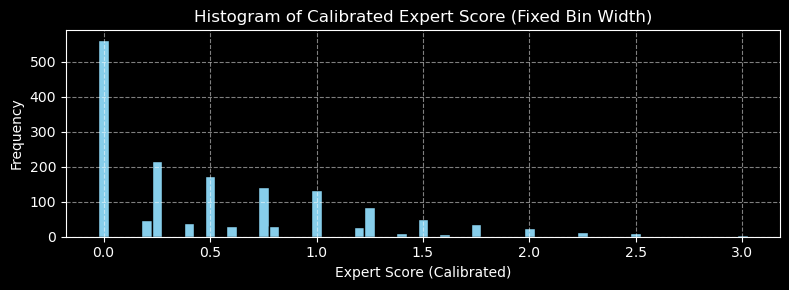

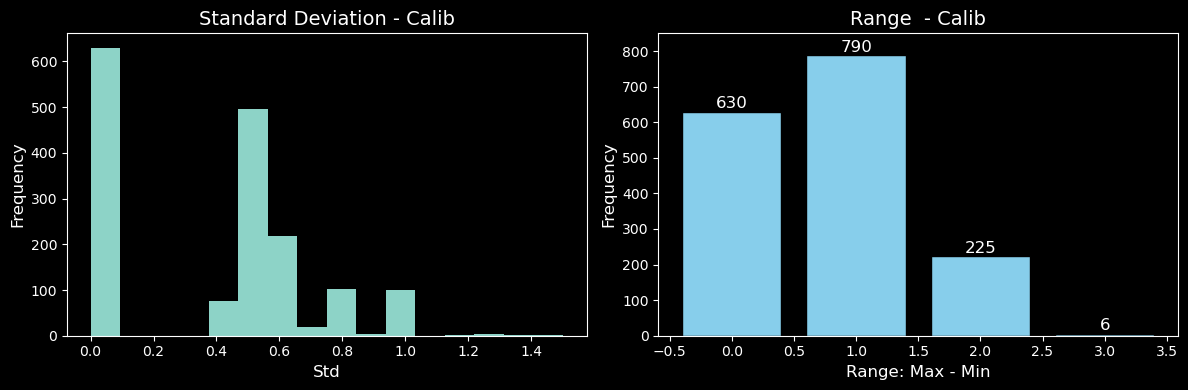

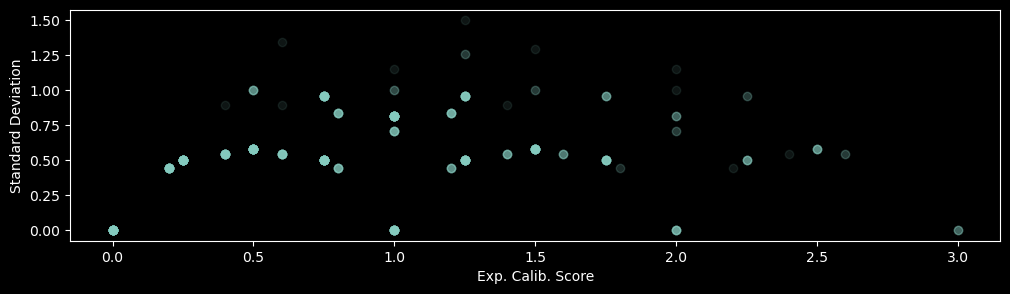

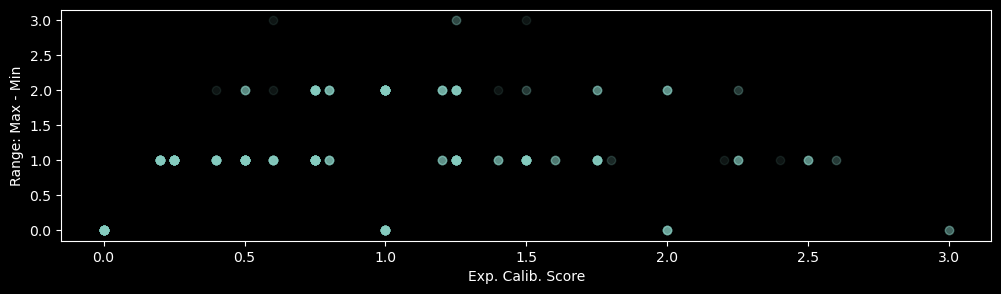

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.


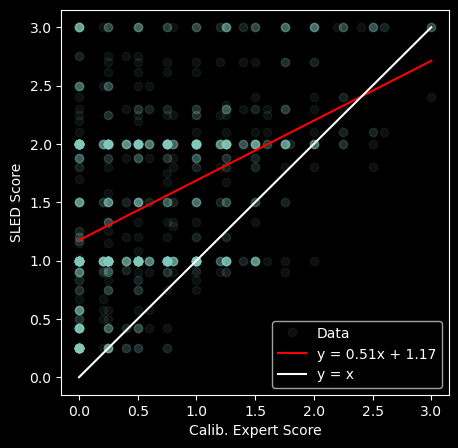

Percentage of points below y = x: 7.15%


In [13]:
# Studying Calibrated Score

# Distribution
counts = data_zoo_tmp['calib'].value_counts().sort_index()
plt.figure(figsize=(8, 3))
plt.bar(counts.index, counts.values, width=0.05, color='skyblue', edgecolor='black')
#plt.yscale('log')
plt.xlabel('Expert Score (Calibrated)')
plt.ylabel('Frequency')
plt.title('Histogram of Calibrated Expert Score (Fixed Bin Width)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# How do experts agree after removing outliers?

#For Range histogram
range_counts = data_zoo_tmp['calib_range'].value_counts().sort_index()
all_values = [0, 1, 2, 3]
range_counts = range_counts.reindex(all_values, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  
axes[0].hist(data_zoo_tmp['calib_std'], bins='auto')
axes[0].set_title('Standard Deviation - Calib', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xlabel('Std', fontsize=12)
axes[1].bar(range_counts.index, range_counts.values, color='#87CEEB', edgecolor='black')
axes[1].set_title('Range  - Calib', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_xlabel('Range: Max - Min', fontsize=12)
axes[1].set_ylim(0, 850)
for i, count in enumerate(range_counts.values):
    axes[1].text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

#Is there a relationship between average Exp. Score & Standard deviation or Range?

#Exp. score vs std
plt.figure(figsize=(12,3))
plt.plot(data_zoo_tmp['calib'], data_zoo_tmp['calib_std'], 'o', alpha=0.1)
plt.xlabel('Exp. Calib. Score')
plt.ylabel('Standard Deviation')
plt.show()

#Exp. score vs range
plt.figure(figsize=(12,3))
plt.plot(data_zoo_tmp['calib'], data_zoo_tmp['calib_range'], 'o', alpha=0.1)
plt.xlabel('Exp. Calib. Score')
plt.ylabel('Range: Max - Min')
plt.show()

#Is there a correlation between the calib Exp. score and the SLED score? I think stays the same

slope, intercept, r_value, p_value, std_err = linregress(data_zoo_tmp['calib'], data_zoo_tmp['score'])
x_fit = np.linspace(data_zoo_tmp['calib'].min(), data_zoo_tmp['calib'].max(), 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(5,5))
plt.plot(data_zoo_tmp['calib'], data_zoo_tmp['score'], 'o', alpha=0.08, label='Data')
plt.plot(x_fit, y_fit, 'r-', label=f'y = {slope:.2f}x + {intercept:.2f}')
plt.plot(x_fit, x_fit, 'r-', label=f'y = x', color='white')
plt.xlabel('Calib. Expert Score')
plt.ylabel('SLED Score')
plt.legend()
plt.show()

below_y_equals_x = (data_zoo_tmp['score'] < data_zoo_tmp['average']).sum()
total_points = len(data_zoo_tmp)
percentage_below = 100 * below_y_equals_x / total_points
print(f"Percentage of points below y = x: {percentage_below:.2f}%")